# US Mobility Exploratory Analysis

Originally, the goal of this section was to measure, for each county in the United States, the lead or lag of a reduction in mobility relative to any increase in number of coronavirus cases. After examining the Descartes Labs mobility data in detail, it became clear that that dataset showed very few counties had reduced movement completely to zero. In addition, most counties began reducing mobility at approximately the same time.

Thus, the analysis was revised to identify common patterns of reduction in mobility, which may then in turn be used as features for a predictive model. 

The approach is to use the k-means clustering algorithm implemented in the sklearn Python library to cluster counties by the time series of the m50_index. The k-means algorithm iteratively changes the class membership of each county to the class of the closest centroid, which is recomputed at the end of each iteration. This sequence of operations is repeated until a maximum number of iterations is reached or a change index falls below a specified tolerance. For a given county, the m50_index on each day is treated as an individual feature and thus, a cluster's centroid is itself a sequence of m50_index's that can be interpreted as a time series. 

First, the Cluster_TS class, with several useful methods, is defined to aid in the analysis. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
class Cluster_TS:
    
    def __init__(self, df, nclusters = 4):
        
        #initialize Cluster_TS object
        #error handling of arguments is not included
        #nclusters should be an integer > 0
        #df is the dataset dataframe, which should have each time series as a row with an appropriate index
        #columns should be the column names, in order of increasing time, of data in the series
        
        import pandas as pd
        import numpy as np
        from sklearn.cluster import KMeans
        import matplotlib.pyplot as plt
        %matplotlib notebook
        
        self.nclusters = nclusters
        self.df = df
        self.columns = df.columns.tolist()
        self.clusters_df = pd.DataFrame()
        self.classes_df = pd.DataFrame()
        self.class_data_df = pd.DataFrame()
        
    def cluster(self, nclusters = None, maxiter = 300, tol = 0.0001):
        
        
        #can change object's number of clusters here
        #nclusters should be an integer
        
        if nclusters != None:
            self.nclusters = nclusters
        
        #convert self.df into numpy array of right form and cluster using KMeans object
        
        nparray = self.df.to_numpy()
        
        #fit Kmeans clustering model
        kmeans = KMeans(n_clusters = self.nclusters, random_state = 0).fit(nparray)
        
        #save cluster centroids to a dataframe
        #pandas dataframe by default has indices from 0 to n-1, in line with the order of the 
        #centroid rows
        self.clusters_df = pd.DataFrame(data = kmeans.cluster_centers_, columns = self.columns)
        
        #save class memberships
        
        temp = pd.DataFrame(kmeans.predict(nparray), columns = ['class'])
        self.classes_df = temp.copy()
        
        #dataframe of counts and cumulative % of rows of each cluster
        
        temp['num'] = 1
        temp = temp.groupby('class').count().sort_values(by = 'num', ascending = False)
        temp['numcumsumdescpct'] = 0
        
        #calculate cumulative sum
        for i in range(temp.shape[0]):
            temp.iloc[i, 1] = temp.iloc[0:i+1, 0].sum()
        
        #scale cumulative sum by total to get fraction
        temp['numcumsumdescpct'] = temp['numcumsumdescpct']/temp['numcumsumdescpct'].max()
        
        self.class_data_df = temp
        
    def plot_top_centroids(self, start=0, end = 5, xtick_rotation = 0, 
                           xlabel = None, ylabel = None, title = None, legend = False):
        
        #plots top (end - start) time series. end is the last index+1
        
        plt.figure()
        for i in range(start, end):
            
            plt.plot(self.columns, self.clusters_df.loc[self.class_data_df.index.tolist()[i], :].to_numpy())
        
        plt.xticks(rotation = xtick_rotation)
            
        if xlabel is not None:
            plt.xlabel(xlabel)
                
        if ylabel is not None:
            plt.ylabel(ylabel)
                
        if title is not None:
            plt.title(title)
            
        if legend:
            labels = self.class_data_df.index.tolist()[start: end]
            plt.legend(labels)
            
    def plot_cluster(self, cluster_index, xtick_rotation = 0, alpha = 0.2,
                     xlabel = None, ylabel = None, title = None):
        
        plt.figure()
        
        plt.title(str(self.class_data_df.loc[cluster_index, 'num']) + ' in Cluster ' + str(cluster_index))
        
        plt.legend(['Cluster ' + str(cluster_index)])
        
        #plot rows in cluster
        for i in range(self.classes_df.shape[0]):
            if self.classes_df.iloc[i]['class'] == cluster_index:
                plt.plot(self.columns, self.df[self.columns].iloc[i].to_numpy(), alpha = alpha, c = 'b')
        
        #plot cluster centroid
        plt.plot(self.columns, self.clusters_df.loc[cluster_index, self.columns].to_numpy(), c = 'r')
        
        plt.xticks(rotation = xtick_rotation)
        
        if xlabel is not None:
            plt.xlabel(xlabel)
                
        if ylabel is not None:
            plt.ylabel(ylabel)
                
        if title is not None:
            plt.title(title)
            

In [3]:
dl = pd.read_csv('dl-4-23-fa.csv').set_index('fips')
dl.head()

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-21,2020-04-22,2020-04-23,2020-04-20
fips,,,,,,,,,,,,,,,,,,,,,
1,79.0,98.0,100.0,96.0,104.0,123.0,107.0,80.0,103.0,103.0,...,51.0,56.0,59.0,68.0,49.0,4.0,62.0,62.0,47.0,0.0
1001,49.0,100.0,95.0,95.0,100.0,116.0,79.0,58.0,108.0,98.0,...,36.0,42.0,45.0,56.0,34.0,0.0,48.0,46.0,35.0,0.0
1003,81.0,100.0,95.0,90.0,102.0,114.0,95.0,82.0,96.0,99.0,...,49.0,52.0,53.0,57.0,43.0,16.0,58.0,59.0,36.0,0.0
1005,90.0,107.0,100.0,70.0,88.0,118.0,141.0,79.0,98.0,93.0,...,51.0,54.0,62.0,67.0,58.0,7.0,71.0,78.0,50.0,0.0
1007,53.0,95.0,100.0,94.0,111.0,133.0,112.0,51.0,124.0,100.0,...,51.0,50.0,55.0,55.0,45.0,4.0,59.0,53.0,35.0,0.0


In [15]:
dl_cluster = Cluster_TS(dl)
dl_cluster.cluster(1000, maxiter = 1000, tol = 0.000001)

In [23]:
dl_cluster.class_data_df.head(10)

,num,numcumsumdescpct
class,,
31,48,0.017641
154,32,0.029401
606,28,0.039691
431,27,0.049614
401,27,0.059537
105,26,0.069092
34,23,0.077545
670,23,0.085998
886,22,0.094083


In [26]:
dl_cluster.class_data_df.tail(10)

,num,numcumsumdescpct
class,,
369,1,0.996692
370,1,0.997060
371,1,0.997427
372,1,0.997795
373,1,0.998162
374,1,0.998530
375,1,0.998897
377,1,0.999265
378,1,0.999632


<IPython.core.display.Javascript object>


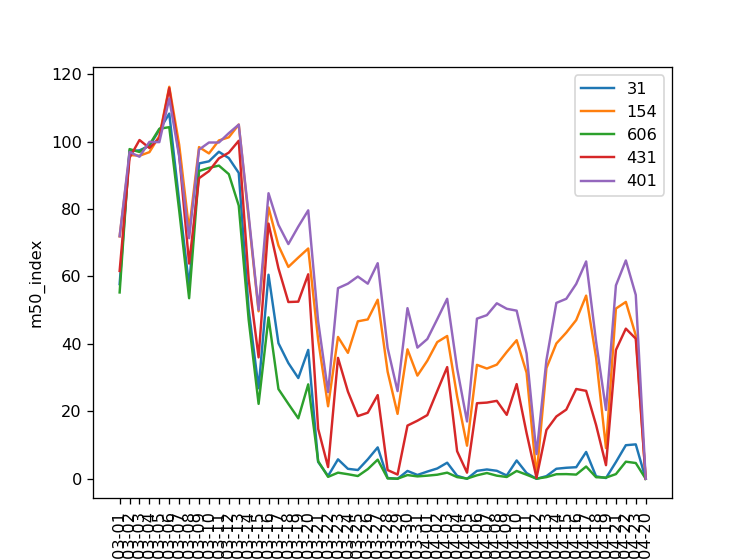

In [30]:
dl_cluster.plot_top_centroids(end = 5, xtick_rotation = 90, ylabel = 'm50_index', legend = True)

<IPython.core.display.Javascript object>


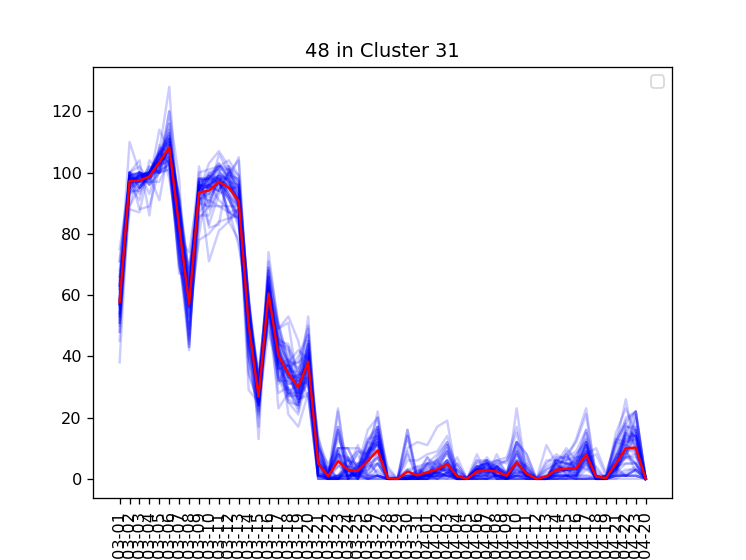

In [32]:
dl_cluster.plot_cluster(31, xtick_rotation = 90)